In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import levy_stable
from scipy.stats import norm
from scipy.stats import kruskal

In [132]:
def overlapping_returns(daily_returns, period=10):
    """
    Calculates overlapping returns for a given period from daily returns.

    Args:
        daily_returns (array-like): Array of daily returns (as decimals, e.g., 0.01 for 1%).
        period (int): The period for calculating overlapping returns (default is 10).

    Returns:
        np.ndarray: An array of overlapping returns.

    Raises:
        ValueError: If the length of `daily_returns` is less than the specified `period`.

    Example:
        >>> daily_returns = [1, 0.5, -0.2, 0.3, 0.4]
        >>> overlapping_returns(daily_returns, period=3)
        array([...])  # Example output
    """
    if len(daily_returns) < period:
        raise ValueError("The length of `daily_returns` must be greater than or equal to `period`.")

    # Convert daily returns from percentages to decimals
    daily_returns_fraction = np.array(daily_returns) / 100.0

    # Compute overlapping returns using a sliding window
    overlapping = [
        np.prod(1 + daily_returns_fraction[i:i + period]) - 1
        for i in range(len(daily_returns) - period + 1)
    ]

    return np.array(overlapping)


In [133]:
def generate_quantile_noise(quantile, n_days, alpha, beta, gamma, delta):
    """
    Generates quantile noise based on the Lévy stable distribution and overlapping returns.

    Args:
        quantile (float): The quantile to calculate (e.g., 0.05 for the 5th percentile).
        n_days (int): Number of days for which to generate the noise.
        alpha (float): Stability parameter (0 < alpha <= 2) of the Lévy stable distribution.
        beta (float): Skewness parameter (-1 <= beta <= 1) of the Lévy stable distribution.
        gamma (float): Scale parameter (> 0) of the Lévy stable distribution.
        delta (float): Location parameter of the Lévy stable distribution.

    Returns:
        float: The calculated quantile of the overlapping 10-day returns.

    Raises:
        ValueError: If `quantile` is not between 0 and 1.
        ValueError: If `n_days` is not a positive integer.

    Example:
        >>> quantile = 0.05
        >>> n_days = 100
        >>> alpha, beta, gamma, delta = 1.7, 0, 1, 0
        >>> generate_quantile_noise(quantile, n_days, alpha, beta, gamma, delta)
        -0.0325  # Example output
    """
    if not (0 <= quantile <= 1):
        raise ValueError("The `quantile` must be between 0 and 1.")
    if n_days <= 0:
        raise ValueError("`n_days` must be a positive integer.")

    # Generate noise using the Lévy stable distribution
    noise = levy_stable.rvs(alpha, beta, scale=gamma, loc=delta, size=n_days)

    # Calculate overlapping returns for 10-day periods
    noise_10d = overlapping_returns(noise)

    # Return the specified quantile
    return np.quantile(noise_10d, quantile)


In [134]:
def generate_quantile_ar(quantile, n_days, alpha, beta, gamma, delta):
    """
    Generates quantile noise based on an autoregressive (AR) process with overlapping returns.

    Args:
        quantile (float): The quantile to calculate (e.g., 0.05 for the 5th percentile).
        n_days (int): Number of days for which to generate the AR series.
        alpha (float): Stability parameter (0 < alpha <= 2) of the Lévy stable distribution.
        beta (float): Skewness parameter (-1 <= beta <= 1) of the Lévy stable distribution.
        gamma (float): Scale parameter (> 0) of the Lévy stable distribution.
        delta (float): Location parameter of the Lévy stable distribution.

    Returns:
        float: The calculated quantile of the overlapping 10-day returns from the AR series.

    Raises:
        ValueError: If `quantile` is not between 0 and 1.
        ValueError: If `n_days` is not a positive integer.

    Example:
        >>> quantile = 0.05
        >>> n_days = 100
        >>> alpha, beta, gamma, delta = 1.7, 0, 1, 0
        >>> generate_quantile_ar(quantile, n_days, alpha, beta, gamma, delta)
        -0.0456  # Example output
    """
    if not (0 <= quantile <= 1):
        raise ValueError("The `quantile` must be between 0 and 1.")
    if n_days <= 0:
        raise ValueError("`n_days` must be a positive integer.")

    # Generate noise using the Lévy stable distribution
    noise = levy_stable.rvs(alpha, beta, scale=gamma, loc=delta, size=n_days)

    # Define the autoregressive coefficient
    phi = 0.8

    # Initialize the AR series with the first noise value
    ar_series = [noise[0]]

    # Generate the AR series using the recurrence relation
    for t in range(1, n_days):
        ar_series.append(phi * ar_series[-1] + noise[t])

    # Calculate overlapping returns for 10-day periods
    ar_series_10d = overlapping_returns(ar_series)

    # Return the specified quantile
    return np.quantile(ar_series_10d, quantile)


In [136]:
def generate_quantile_cs(quantile, n_days, alpha, beta, gamma, delta):
    """
    Generates quantile noise based on a complex time series with a trend, seasonality, 
    and random noise, combined with overlapping returns.

    Args:
        quantile (float): The quantile to calculate (e.g., 0.05 for the 5th percentile).
        n_days (int): Number of days for which to generate the complex series.
        alpha (float): Stability parameter (0 < alpha <= 2) of the Lévy stable distribution.
        beta (float): Skewness parameter (-1 <= beta <= 1) of the Lévy stable distribution.
        gamma (float): Scale parameter (> 0) of the Lévy stable distribution.
        delta (float): Location parameter of the Lévy stable distribution.

    Returns:
        float: The calculated quantile of the overlapping 10-day returns from the complex series.

    Raises:
        ValueError: If `quantile` is not between 0 and 1.
        ValueError: If `n_days` is not a positive integer.

    Example:
        >>> quantile = 0.05
        >>> n_days = 100
        >>> alpha, beta, gamma, delta = 1.7, 0, 1, 0
        >>> generate_quantile_cs(quantile, n_days, alpha, beta, gamma, delta)
        -0.0254  # Example output
    """
    if not (0 <= quantile <= 1):
        raise ValueError("The `quantile` must be between 0 and 1.")
    if n_days <= 0:
        raise ValueError("`n_days` must be a positive integer.")

    # Generate noise using the Lévy stable distribution
    noise = levy_stable.rvs(alpha, beta, scale=gamma, loc=delta, size=n_days)

    # Initialize the complex series with the first noise value
    complex_series = [noise[0]]

    # Generate the complex series with trend and seasonality
    for t in range(1, n_days):
        trend = 0.03 * t  # Linear trend
        seasonal = 5 * np.sin(np.pi * t / 500)  # Sinusoidal seasonality
        complex_series.append(trend + seasonal + noise[t])

    # Convert the complex series to a NumPy array
    complex_series = np.array(complex_series)

    # Calculate overlapping returns for 10-day periods
    complex_series_10d = overlapping_returns(complex_series)

    # Return the specified quantile
    return np.quantile(complex_series_10d, quantile)


In [150]:
def plot_hist(data, bins=10, title="Histogram", xlabel="Value", ylabel="Frequency"):
    """
    Creates a histogram to visualize the distribution of values.

    Args:
        data (array-like): Array of numerical values.
        bins (int): Number of bins (bars) for the histogram (default is 10).
        title (str): Title of the histogram.
        xlabel (str): Label for the X-axis.
        ylabel (str): Label for the Y-axis.

    Returns:
        None

    Example:
        >>> data = [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]
        >>> plot_hist(data, bins=4, title="Example Histogram", xlabel="Value", ylabel="Frequency")
    """
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError("`bins` must be a positive integer.")
    if not isinstance(data, (list, np.ndarray)):
        raise TypeError("`data` must be a list or a NumPy array.")

    # Configure the figure size and create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, edgecolor='black', alpha=0.7)

    # Set the title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Set a logarithmic scale for the Y-axis
    plt.yscale('log')

    # Add grid lines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()


In [138]:
def st_error_test(data):
    """
    Calculates the standard error over a cumulative series of simulations 
    and plots its convergence.

    Args:
        data (array-like): Array of numerical values.

    Returns:
        None

    Example:
        >>> data = np.random.randn(1000)  # Example dataset
        >>> st_error_test(data)
    """
    if not isinstance(data, (list, np.ndarray)):
        raise TypeError("`data` must be a list or a NumPy array.")

    # Calculate the cumulative mean
    cumulative_mean = np.cumsum(data) / np.arange(1, len(data) + 1)

    # Calculate the cumulative standard deviation
    cumulative_std = np.sqrt(np.cumsum((data - cumulative_mean) ** 2) / np.arange(1, len(data) + 1))

    # Calculate the standard error
    standard_error = cumulative_std / np.sqrt(np.arange(1, len(data) + 1))

    # Plot the standard error
    plt.figure(figsize=(10, 6))
    plt.plot(standard_error, label="Standard Error", color="blue")
    plt.title("Convergence: Standard Error")
    plt.xlabel("Number of Simulations")
    plt.ylabel("Standard Error")
    plt.grid(axis='both', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()


In [139]:
def conf_level_test(data):
    """
    Calculates the cumulative mean and its 95% confidence interval over a series of simulations,
    and visualizes the results.

    Args:
        data (array-like): Array of numerical values.

    Returns:
        None

    Example:
        >>> data = np.random.randn(1000)  # Example dataset
        >>> conf_level_test(data)
    """
    if not isinstance(data, (list, np.ndarray)):
        raise TypeError("`data` must be a list or a NumPy array.")

    # Calculate the cumulative mean
    cumulative_mean = np.cumsum(data) / np.arange(1, len(data) + 1)

    # Calculate the cumulative standard deviation
    cumulative_std = np.sqrt(np.cumsum((data - cumulative_mean) ** 2) / np.arange(1, len(data) + 1))

    # Calculate the standard error
    standard_error = cumulative_std / np.sqrt(np.arange(1, len(data) + 1))

    # Calculate the 95% confidence interval
    z = norm.ppf(0.975)  # Z-score for 95% confidence
    lower_bound = cumulative_mean - z * standard_error
    upper_bound = cumulative_mean + z * standard_error

    # Plot the cumulative mean and confidence interval
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_mean, label="Cumulative Mean", color="blue")
    plt.fill_between(
        range(len(cumulative_mean)),
        lower_bound,
        upper_bound,
        color="blue",
        alpha=0.2,
        label="95% Confidence Interval"
    )
    plt.title("Confidence Interval for the Mean")
    plt.xlabel("Number of Simulations")
    plt.ylabel("Mean Value")
    plt.legend()
    plt.grid(axis="both", linestyle="--", alpha=0.7)
    plt.show()



In [140]:
def kruskal_test(data, n_groups=5):
    """
    Performs the Kruskal-Wallis test to check for significant differences between multiple groups.

    Args:
        data (array-like): Array of numerical values.
        n_groups (int): Number of groups to split the data into (default is 5).

    Returns:
        None

    Example:
        >>> data = np.random.randn(1000)  # Example dataset
        >>> kruskal_test(data, n_groups=5)
    """
    if not isinstance(data, (list, np.ndarray)):
        raise TypeError("`data` must be a list or a NumPy array.")
    if not isinstance(n_groups, int) or n_groups <= 1:
        raise ValueError("`n_groups` must be an integer greater than 1.")
    
    # Divide the data into the specified number of groups
    group_size = len(data) // n_groups
    groups = [data[i * group_size:(i + 1) * group_size] for i in range(n_groups)]
    
    # Perform the Kruskal-Wallis test
    stat, p_value = kruskal(*groups)

    # Print the test results
    print('Kruskal-Wallis Test:')
    print(f"Test Statistic: {stat}")
    print(f"p-value: {p_value}")

    # Interpretation of the result
    alpha = 0.05  # Significance level
    if p_value > alpha:
        print("No significant differences between groups. Convergence is achieved.")
    else:
        print("Significant differences found between groups. Increase the number of simulations.")


# Researh

In [141]:
# Distribution parameters
alpha = 1.7  # Stability parameter of the Levy distribution
beta = 0.0  # Skewness parameter of the Levy distribution
gamma = 1.0  # Scale parameter of the Levy distribution
delta = 1.0  # Location parameter of the Levy distribution

epsilon = 10**-5  # Convergence threshold for simulations

# Time series generation parameters
n_days = 750  # Number of days in the time series
quantile = 0.01  # Quantile to be calculated

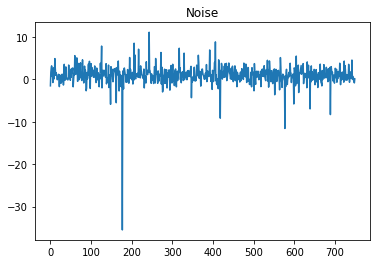

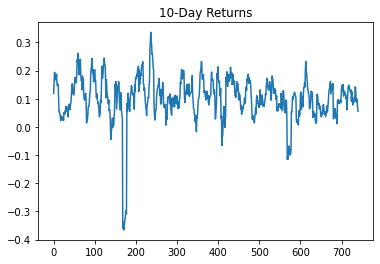

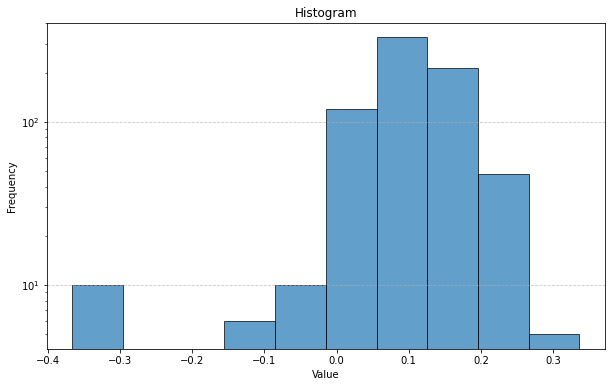

0.01-quantile: -0.3063180405221999


In [151]:
# Generate noise using the Levy stable distribution
noise = levy_stable.rvs(alpha, beta, scale=gamma, loc=delta, size=n_days)

# Plot the generated noise
plt.plot(noise)
plt.title("Noise")
plt.show()

# Calculate the 10-day returns
noise_10d = overlapping_returns(noise)

# Plot the 10-day returns
plt.plot(noise_10d)
plt.title("10-Day Returns")
plt.show()

# Plot histogram of the 10-day returns
plot_hist(noise_10d)

# Print the quantile value
print(f"{quantile}-quantile: {np.quantile(noise_10d, quantile)}")


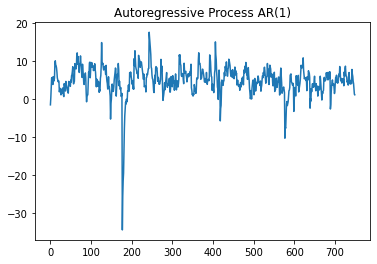

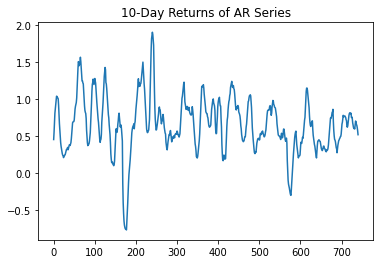

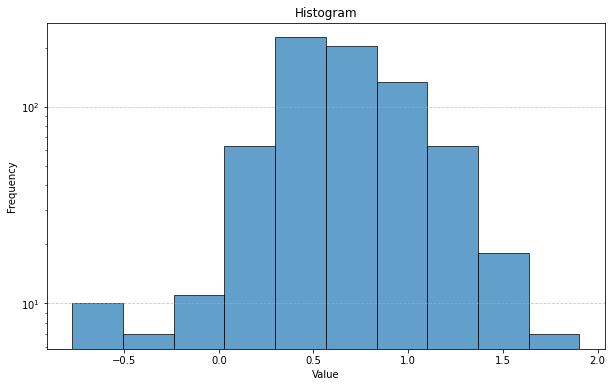

0.01-quantile: -0.6114806837082675


In [152]:
# Set AR(1) process parameters
phi = 0.8  # Autoregression coefficient
ar_series = [noise[0]]  # Initial value

# Generate AR(1) time series
for t in range(1, n_days):
    ar_series.append(phi * ar_series[-1] + noise[t])

# Convert to numpy array for easier manipulation
ar_series = np.array(ar_series)

# Plot AR(1) process
plt.plot(ar_series)
plt.title("Autoregressive Process AR(1)")
plt.show()

# Calculate the 10-day returns for the AR series
ar_series_10d = overlapping_returns(ar_series)

# Plot the 10-day returns for the AR series
plt.plot(ar_series_10d)
plt.title("10-Day Returns of AR Series")
plt.show()

# Plot histogram of the 10-day returns
plot_hist(ar_series_10d)

# Print the quantile value
print(f"{quantile}-quantile: {np.quantile(ar_series_10d, quantile)}")


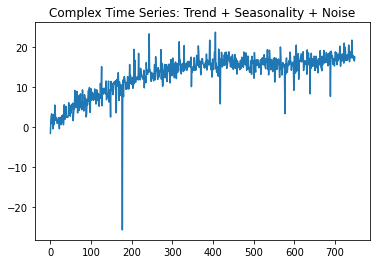

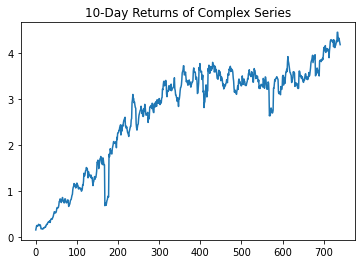

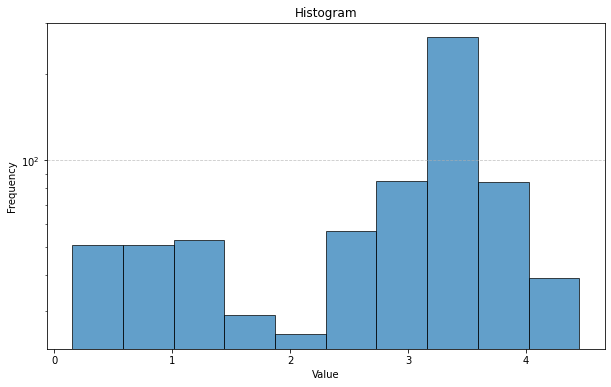

0.01-quantile: 0.1932545063069356


In [159]:
# Generate complex time series with trend, seasonality, and noise
complex_series = [noise[0]]
for t in range(1, n_days):
    trend = 0.03 * t  # Linear trend
    seasonal = 5 * np.sin(np.pi * t / 500)  # Seasonal component
    complex_series.append(trend + seasonal + noise[t])

# Convert to numpy array for easier manipulation
complex_series = np.array(complex_series)

# Plot complex time series
plt.plot(complex_series)
plt.title("Complex Time Series: Trend + Seasonality + Noise")
plt.show()

# Calculate the 10-day returns for the complex series
complex_series_10d = overlapping_returns(complex_series)

# Plot the 10-day returns for the complex series
plt.plot(complex_series_10d)
plt.title("10-Day Returns of Complex Series")
plt.show()

# Plot histogram of the 10-day returns
plot_hist(complex_series_10d)

# Print the quantile value
print(f"{quantile}-quantile: {np.quantile(complex_series_10d, quantile)}")


# Development

In [163]:
# Distribution parameters
alpha = 1.7  # Stability parameter of the Levy distribution
beta = 0.0  # Skewness parameter of the Levy distribution
gamma = 1.0  # Scale parameter of the Levy distribution
delta = 1.0  # Location parameter of the Levy distribution

epsilon = 10**-7  # Convergence threshold for simulations

# Time series generation parameters
n_days = 750  # Number of days in the time series
quantile = 0.01  # Quantile to be calculated

In [147]:
def main(n_days, alpha, beta, gamma, delta, quantile, type=0, epsilon=1e-5):
    """
    Runs simulations and calculates quantiles for different types of processes, 
    then evaluates convergence using statistical tests and plots.

    Args:
        n_days (int): Number of days/simulations to run.
        alpha (float): Alpha parameter for the distribution (e.g., for Levy stable).
        beta (float): Beta parameter for the distribution.
        gamma (float): Gamma parameter for the distribution.
        delta (float): Delta parameter for the distribution.
        quantile (float): Quantile to be calculated (e.g., 0.95).
        type (int): Type of simulation process (0: noise, 1: AR, 2: complex series).
        epsilon (float): Convergence criterion for the simulations.

    Returns:
        None
    """
    if type == 0:
        quantiles = [generate_quantile_noise(quantile, n_days, alpha, beta, gamma, delta) for _ in range(2)]
        while abs(np.mean(quantiles) - np.mean(quantiles[:-1])) > epsilon:
            quantiles.append(generate_quantile_noise(quantile, n_days, alpha, beta, gamma, delta))
    elif type == 1:
        quantiles = [generate_quantile_ar(quantile, n_days, alpha, beta, gamma, delta) for _ in range(2)]
        while abs(np.mean(quantiles) - np.mean(quantiles[:-1])) > epsilon:
            quantiles.append(generate_quantile_ar(quantile, n_days, alpha, beta, gamma, delta))
    elif type == 2:
        quantiles = [generate_quantile_cs(quantile, n_days, alpha, beta, gamma, delta) for _ in range(2)]
        while abs(np.mean(quantiles) - np.mean(quantiles[:-1])) > epsilon:
            quantiles.append(generate_quantile_cs(quantile, n_days, alpha, beta, gamma, delta))
    else:
        print("Error: Invalid simulation type")
        return

    print(f"Total number of simulations: {len(quantiles)}")
    print(f"Mean of quantiles: {np.mean(quantiles)}")

    # Plotting histogram
    plot_hist(np.array(quantiles), bins=10)

    # Statistical tests
    kruskal_test(quantiles)
    conf_level_test(quantiles)
    st_error_test(quantiles)

    # Calculate and display mean and standard deviation
    mean_quantile = np.mean(quantiles)
    std_quantile = np.std(quantiles)
    print(f"Mean of quantile: {mean_quantile}")
    print(f"Standard deviation: {std_quantile}")

    # Theoretical error estimate
    error_estimate = std_quantile / np.sqrt(len(quantiles))
    print(f"Error estimate: {error_estimate}")


Total number of simulations: 4354
Mean of quantiles: -0.010539902505104112


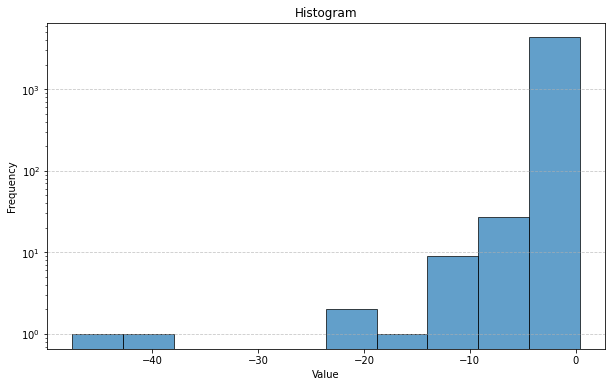

Kruskal-Wallis Test:
Test Statistic: 4.285662421010784
p-value: 0.36872389854533333
No significant differences between groups. Convergence is achieved.


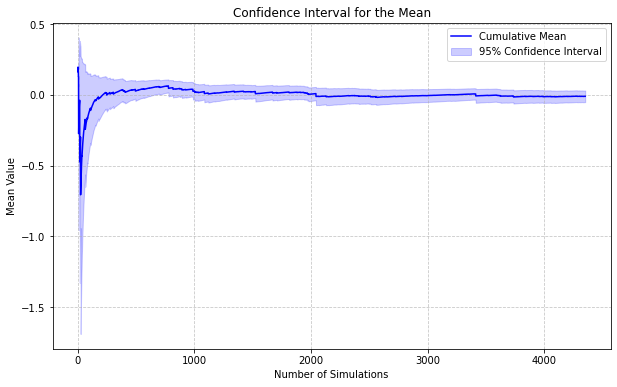

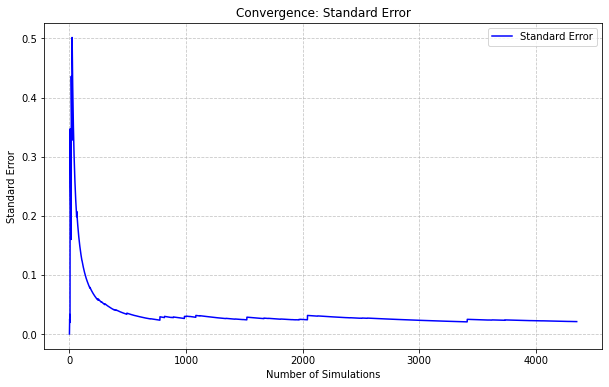

Mean of quantile: -0.010539902505104112
Standard deviation: 1.3828628546318047
Error estimate: 0.020957279176077186


In [166]:
# Calling the main function with specified parameters
main(
    n_days=n_days,         # Number of days in the time series
    alpha=alpha,           # Stability parameter of the Levy distribution
    beta=beta,             # Skewness parameter of the Levy distribution
    gamma=gamma,           # Scale parameter of the Levy distribution
    delta=delta,           # Location parameter of the Levy distribution
    quantile=quantile,     # Quantile to be calculated
    type=2,                # Type of process (0: noise, 1: AR, 2: complex series)
    epsilon=epsilon       # Convergence threshold for simulations
)
